In [1]:
# necessary libraries
using Plots
using LinearAlgebra
using ForwardDiff
using Optim
using Printf
Base.show(io::IO, f::Float64) = @printf(io, "%1.3f", f)

In [2]:
# Rosenbrock function
f_rb_quad(x, y) = (1-x)^2 + 100*(4y - x^2)^2 #quadratic form
f_rb(x) = (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2 # vector form
∇f_rb(x) = [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]
h(x) = ForwardDiff.hessian(f_rb, x)

function g!(storage, x)
    storage[1] = (2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1))
    storage[2] = (-800*(x[1]^2 - 4x[2]))
end

function h!(storage, x)
    storage[1, 1] = 1200x[1]^2 - 1600x[2] + 2
    storage[1, 2] = -1600x[1]
    storage[2, 1] = -1600x[1]
    storage[2, 2] = 3200
    
end

h! (generic function with 1 method)

In [3]:
function rosenplot(f; xlims=(-3,2), ylims=(-0.5,2))
    x = xlims[1]:0.01:xlims[2]
    y = ylims[1]:0.01:ylims[2]
    contour(x, y, f,
        size=(800, 250),
        framestyle=:box,
        color = cgrad(:viridis),
        levels=[2,10,50,200,500],
        clims=(0, 601),
        legend=(loc=:outertopright),
        xlims=xlims,
        ylims=ylims,
    )
end

rosenplot (generic function with 1 method)

# BFGS and L-BFGS from Optim

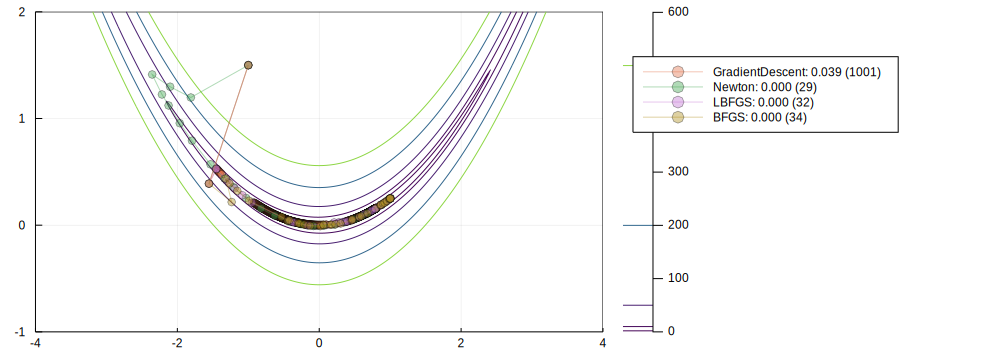

In [4]:
base = rosenplot(f_rb_quad, xlims=(-4, 4), ylims=(-1, 2))

x0 = [-1.0, 1.5]
# Try different Newton's Method
for opt in [GradientDescent(), Newton(), LBFGS(), BFGS()]
    funname = split(string(opt),"{")[1]
    res = optimize(f_rb, g!, h!, x0, opt,
                   Optim.Options(iterations = 1000,
                                 store_trace = true,
                                 f_tol = 1e-4,
                                 g_tol=1e-2,
                                 extended_trace = true)
                  )
    tmp = Optim.x_trace(res)
    xs_optim = hcat(tmp...)
    
    plot!(base, [xs_optim[1,:]], [xs_optim[2,:]], alpha=0.4, m=:o, label=string(funname, ": ", res.minimum, " (", size(xs_optim)[2], ")"))
end

plot!(size=(1000, 360))

# Line Search

In [5]:
function line_search(f, ∇, x, d; α=5, β=1e-4, σ=0.1, max_iter=20) 
    y0, g0, y_prev, α_prev = f(x)[1], ∇(x)⋅d, NaN, 0
    αlo, αhi = NaN, NaN
    # bracket phase
    while true
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || (!isnan(y_prev) && y ≥ y_prev) 
            αlo, αhi = α_prev, α
            break 
        end
                
        g = ∇(x + α*d)⋅d 
        if abs(g) ≤ -σ*g0
            return α 
        elseif g ≥ 0
            αlo, αhi = α, α_prev
            break 
        end
        y_prev, α_prev, α = y, α, 2α 
    end
    #@show(αlo, αhi)
    # zoom phase
    ylo = f(x + αlo*d)[1]
    n = 0
    while n < max_iter
        α = (αlo + αhi)/2
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || y ≥ ylo #
            αhi = α 
        else
            g = ∇(x + α*d)⋅d 
            if abs(g) ≤ -σ*g0
                return α
            elseif g*(αhi - αlo) ≥ 0
                αhi = αlo 
            end
            αlo = α 
        end
        n += 1
    end
    return α #return something if it fails to find the suitable alpha
end

line_search (generic function with 1 method)

In [6]:
abstract type DescentMethod end

# DFP

In [7]:
mutable struct DFP <: DescentMethod
    x
    α
    Q
end

function step!(M::DFP, f, ∇f)
    Q, g = M.Q, ∇f(M.x)
    d = -Q*g
    d /= norm(d)
    α = line_search(f, ∇f, M.x, d)
    
    # if alpha is too small, use g
    if α < 1e-2
        #println("Use the gradient")
        d = -g
        d /= norm(d)
        α = line_search(f, ∇f, M.x, d)
    end
    
    M.x +=  α*d
    M.α = α
    #@show(M.α)
    
    g′ = ∇f(M.x)
    δ = M.x - x0
    γ = g′ - g
    M.Q[:] = Q - Q*γ*γ'*Q/(γ'*Q*γ) + δ*δ'/(δ'*γ) 
end

function my_optimize(M::DFP, f, ∇f; f_tol=1e-10, g_tol=1e-2, max_iter=1000)
    
    xs = copy(M.x)'
    
    for i in 1:max_iter
        x_prev = M.x
        step!(M::DFP, f, ∇f)
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

my_optimize (generic function with 1 method)

In [ ]:
x0 = [-1.0, 1.5]
N_iter, f_tol, g_tol = 1000, 1e-5, 1e-4

M = DFP(x0, 2e-4, Matrix(1.0I, length(x0), length(x0)))
xs = my_optimize(M, f_rb, ∇f_rb, max_iter=N_iter, f_tol=f_tol, g_tol=g_tol)
base = rosenplot(f_rb_quad, xlims=(-4, 4), ylims=(-1, 2))
plot!(base, [xs[:,1]], [xs[:,2]], m=:o, alpha=0.5, label=string("my_DFP: ", f_rb(xs[end,:]), " (", size(xs)[1], ")"))
plot!(size=(1000, 400))

base

# BFGS

In [ ]:
mutable struct my_BFGS <: DescentMethod
    x
    α
    Q
end

function step!(M::my_BFGS, f, ∇f)
    Q, g, x0 = M.Q, ∇f(M.x), M.x
    d = -Q*g
    d /= norm(d)
    M.α = line_search(f, ∇f, x0, d)
    M.x +=  M.α*d
    
    g′ = ∇f(M.x)
    δ = M.x - x0
    γ = g′ - g
    M.Q[:] = Q - (δ*γ'*Q + Q*γ*δ')/(δ'*γ) + (1 + (γ'*Q*γ)/(δ'*γ))[1]*(δ*δ')/(δ'*γ) 
end

function my_optimize(M::my_BFGS, f, ∇f; f_tol=1e-4, g_tol=1e-2, max_iter=1000)
    
    xs = copy(M.x)'
    
    for i in 1:max_iter
        x_prev = M.x
        step!(M::my_BFGS, f, ∇f)
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

In [ ]:
x0 = [-1.5, 2.0]
N_iter, f_tol, g_tol = 1000, 1e-3, 1e-4

M = my_BFGS(x0, 2e-4, Matrix(1.0I, length(x0), length(x0)))
xs = my_optimize(M, f_rb, ∇f_rb, max_iter=N_iter, f_tol=f_tol, g_tol=g_tol)
base = rosenplot(f_rb_quad, xlims=(-4, 4), ylims=(-1, 2.5))
plot!(base, [xs[:,1]], [xs[:,2]], m=:o, alpha=0.5, label=string("my_BFGS: ", f_rb(xs[end,:]), " (", size(xs)[1], ")"))


for opt in [BFGS()]
    funname = split(string(opt),"{")[1]
    res = optimize(f_rb, g!, h!, x0, opt,
                   Optim.Options(iterations = N_iter,
                                 store_trace = true,
                                 f_tol = f_tol,
                                 g_tol=g_tol,
                                 extended_trace = true)
                  )
    tmp = Optim.x_trace(res)
    xs_optim = hcat(tmp...)
    
    plot!(base, [xs_optim[1,:]], [xs_optim[2,:]], m=:o, alpha=0.5, label=string(funname, ": ", res.minimum, " (", size(xs_optim)[2], ")"))
end

plot!(size=(1000, 400))

base

# LBFGS

In [ ]:
mutable struct my_LBFGS <: DescentMethod
    x
    α
    m
    δs 
    γs 
    qs
end


function step!(M::my_LBFGS, f, ∇f)
    δs, γs, qs, g = M.δs, M.γs, M.qs, ∇f(M.x) 
    m = length(δs)
    if m > 0
        q=g
        for i in m : -1 : 1
            qs[i] = copy(q)
            q -= (δs[i]⋅q)/(γs[i]⋅δs[i])*γs[i] 
        end
        z = (γs[m] .* δs[m] .* q) / (γs[m]⋅γs[m]) 
        for i in 1 : m
            z += δs[i]*(δs[i]⋅qs[i] - γs[i]⋅z)/(γs[i]⋅δs[i]) 
        end
        d = -z
    else
        d = -g
    end
    
    d /= norm(d)
    M.α = line_search(f, ∇f, M.x, d)
    M.x += M.α*d
    # check if reset alpha = 1
    #if f(M.x+d) < f(M.x+α*d)
    #    M.x += d
    #    M.α = 1
    #else
    #    M.x += α*d
    #    M.α = α
    #end
    #@show(M.α)
    
    g′ = ∇f(M.x)
    push!(δs, M.α*d) 
    push!(γs, g′ - g) 
    push!(qs, zeros(length(M.x)))
    while length(δs) > M.m
        popfirst!(δs)
        popfirst!(γs) 
        popfirst!(qs) 
    end
end


function my_optimize(M::my_LBFGS, f, ∇f; f_tol=1e-4, g_tol=1e-2, max_iter=1000)
    
    xs = copy(M.x)'
    
    for i in 1:max_iter
        x_prev = M.x
        step!(M::my_LBFGS, f, ∇f)
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

In [ ]:
x0 = [-1.0, 1.8]
N_iter, f_tol, g_tol = 1000, 1e-6, 1e-4

M = my_LBFGS(x0, 0, 2, [], [], [])
xs = my_optimize(M, f_rb, ∇f_rb, max_iter=N_iter, f_tol=f_tol, g_tol=g_tol)
base = rosenplot(f_rb_quad, xlims=(-4, 4), ylims=(-1, 2))
plot!(base, [xs[:,1]], [xs[:,2]], m=:o, label=string("my_LBFGS: ", f_rb(xs[end,:]), " (", size(xs)[1]-1, ")"))


for opt in [LBFGS()]
    funname = split(string(opt),"{")[1]
    res = optimize(f_rb, g!, h!, x0, opt,
                   Optim.Options(iterations = N_iter,
                                 store_trace = true,
                                 f_tol = f_tol,
                                 g_tol = g_tol,
                                 extended_trace = true)
                  )
    tmp = Optim.x_trace(res)
    xs_optim = hcat(tmp...)
    
    plot!(base, [xs_optim[1,:]], [xs_optim[2,:]], alpha=0.4, m=:o, label=string(funname, ": ", res.minimum, " (", size(xs_optim)[2]-1, ")"))
end


plot!(size=(1000, 400))

base